### 🖋 **Notebook Contents**
0. Initial Setup
1. Business Problem Understanding
2. Glossary

****

## `Initial Setup`

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import missingno as msno

import glob
import sys
import os
import mlflow

# Data Preparation
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error, r2_score

# Model Algorithm (modeling)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# get experiment_id for mlflow and helper function
sys.path.append(os.path.abspath("../src/"))
from get_or_create_mlflow_experiments import get_experiment_id
from helper import skim, adj_r2

import statistics

import warnings
warnings.filterwarnings("ignore")

PROPS = 'color:#080808;font-weight:bold;background-color:#85bb65'
EXP_ID = get_experiment_id('Assignment_JALA') # experiment id

## `Business Problem Understanding`

**Context**:
<br>
**Jala Tech** is an Indonesian startup company that tries to make significant strides in the shrimp industry. Jala serves as a digital ecosystem enabler for the shrimp industry value chain. Here’s what we do:
1. Comprehensive Solutions: Jala provides end-to-end solutions to streamline the shrimp farming process. These solutions aim to enhance productivity, efficiency, and sustainability throughout the entire shrimp cultivation cycle.
2. Revolutionizing Shrimp Farming: Jala’s offerings include advanced technology services such as data analysis and water quality monitoring. By leveraging these tools, they empower shrimp farmers to make informed decisions and optimize their operations.
3. Ecosystem Building: Jala builds an ecosystem within the shrimp industry, helping farmers create efficiency and gain wider and easier market access. Their goal is to increase sustainable productivity in shrimp farming.

The farm management system (JALA App) is one of the solutions that we provide for shrimp farmers. With the JALA App, farmers can manage their shrimp farms better. Farmers can record their data digitally, analyze the data that they have collected, and receive predictive analytics of their shrimp cultivation.

**Problem Statement**:

Asumsi saat ini Petambak masih melakukan _monitoring_ kegiatan mulai dari awal menyebar benur udang hingga memanen udang masih dilakukan secara maunal, belum secara digitalisasi (Realtime) atau memanfaatkan teknologi, sehingga hasil **panen masih belum maksimal**.

**Task**:

1. Evaluate the completeness of data
2. Calculate SR and average growth rate (ADG) of shrimp per cultivation cycle
3. Predictive modeling:
    
    a. Survival Rate (in percentage) forecast for the end of cultivation or at the
    pointed day of cultivation (You need to make sure that the model
    performs well when the cultivation cycle is still ongoing)

    b. Average Body Weight of Shrimp (in grams) forecast
    
    c. Biomass (in kilograms) forecast
    
    d. Revenue forecast that estimates the value of the shrimp when it is
    harvested.
4. Based on the predictive model that you’ve made, Infer what features/variables
that important to make predictions
5. Based on the data that you analyzed, make recommendations on how shrimp
farming should be done to achieve optimal results
6. Deployment that covers:
    
    a. Feature store of engineered features that you made during development
    
    b. Source code (Please upload it into GitHub, and include clear instructions
    on how to set the service and documentation of the API request)

**Goals**:

Farmers can record their data digitally, analyze the data that they have collected, and receive predictive analytics of their shrimp cultivation.

**Analytic Approach**:

With the value that we’re trying to give to farmers, we need to develop accurate robust **predictive analytics** that our farmers can rely on.

## `Glossary`

**1. Survival Rate (SR)**:
<br>
Jumlah (Persentase) ekor udang yang dipanen dalam suatu siklus budidaya terhadap jumlah benur udang yang ditebar. Selama budidaya, SR dapat diestimasi berdasarkan jumlah pakan yang diberikan, kontrol anco, dan program pakan yang digunakan.

**2. Average Daily Gain (ADG)**:
<br>
Average daily gain adalah rerata pertumbuhan berat udang. Nilai ADG diperoleh saat petambak melakukan sampling dan panen. Nilai ADG diperoleh dengan mencari selisih ABW antar sampling yang berdekatan dan membandingkannya dengan jarak waktu (hari) antar sampling.

**3. Average Body Weight (ABW)**
<br>
Rerata berat udang. Nilai ABW diperoleh saat petambak melakukan sampling dan panen. ABW dihitung dalam satuan gram dengan membandingkan total berat udang sampel dibagi dengan jumlah udang yang dijadikan sampel. Selain sampling, informasi estimasi ABW dapat diperoleh berdasarkan usia budidaya, pemberian pakan yang dilakukan, dan estimasi dari program pakan yang digunakan.

******

## `Data Schema`

## `Features Description`

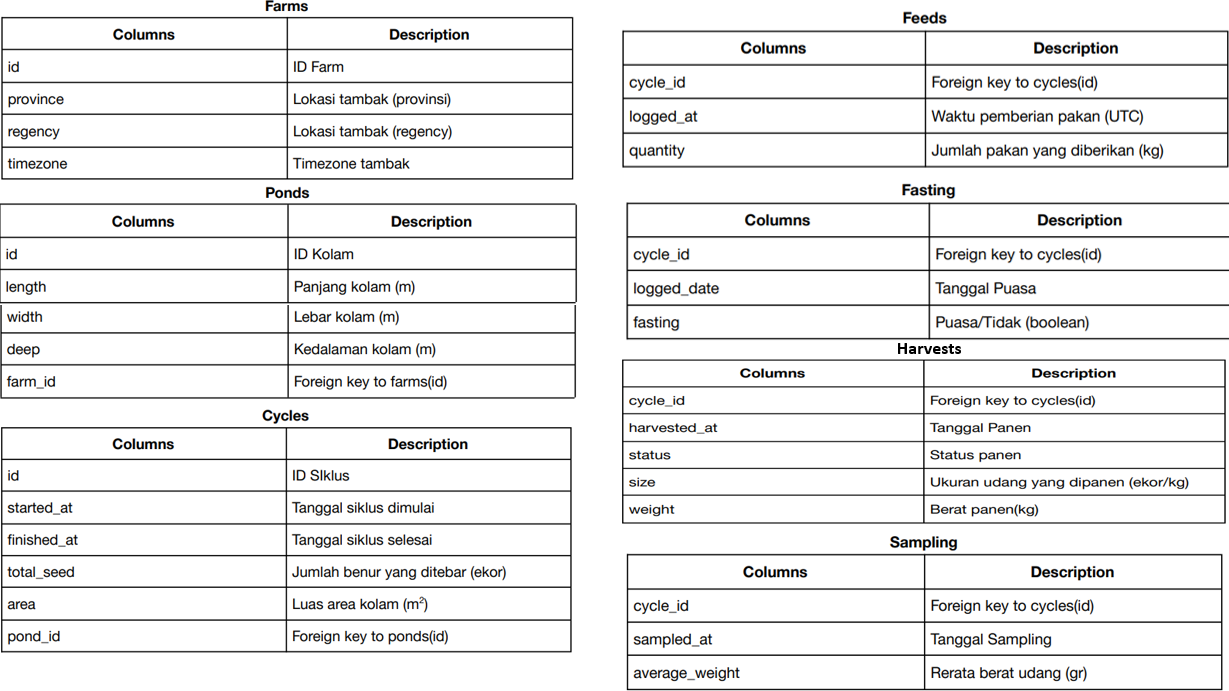

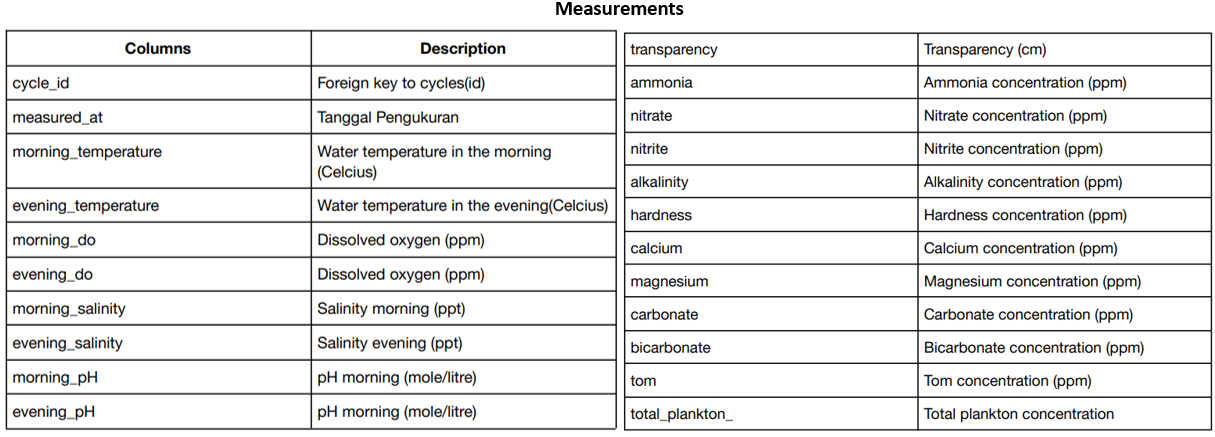

In [2]:
# pd.reset_option('display.max_rows')
# data = pd.read_csv("../data//raw/fasting.csv")
# data

In [3]:
# data = pd.read_csv("../data/raw/fastings.csv")
# data

In [4]:
# data = pd.read_csv("../data/raw/mortalities.csv")
# data

In [5]:
# data = pd.read_csv("../data/raw/feed_tray.csv")
# data

In [6]:
# load data
RAW_DATA_DIR = r"..\data\raw"
file_list = glob.glob(RAW_DATA_DIR + "\*.csv")

In [7]:
# function text handling
def efn(text):
    file = text.split('\\')[-1].replace('.csv','')
    return file

def white_string_to_nan(data):
    return data.replace(r'^\s*$', np.nan, regex=True)

In [8]:
# create dictionary of dataset
dfs = {f'{efn(file)}': white_string_to_nan(pd.read_csv(file, engine="pyarrow")) for file in file_list}
filename = dfs.keys()

In [9]:
# for name in filename:
#     data = pd.read_csv(f"../data/raw/{name}.csv")
#     print(name + str(data.shape))
#     display(data.head())

## `Data Skimming`

1. Skimming each dataset based on:
    - shape
    - duplicate
    - missing values

In [10]:
# check data info
dataInfo = []

for dataset in dfs.keys():
    dataInfo.append({
        'dataset_name' : dataset,
        'shape' : dfs[dataset].shape,
        'columns' : list(dfs[dataset].columns),
        'duplicate' : dfs[dataset].duplicated().sum(),
        'null' : dfs[dataset].isna().sum().sum(),
        'null_columns' : dfs[dataset].columns[dfs[dataset].isna().any()].tolist()
    })

pd.DataFrame(dataInfo)

,dataset_name,shape,columns,duplicate,null,null_columns
0,cycles,"(2617, 24)","[id, pond_id, species_id, total_seed, started_...",50,4983,"[species_id, finished_at, remark, initial_age,..."
1,farms,"(551, 4)","[id, province, regency, timezone]",0,165,"[province, regency]"
2,fasting,"(6189, 3)","[logged_date, cycle_id, fasting]",67,17,[fasting]
3,fastings,"(32379, 3)","[logged_date, cycle_id, fasting]",185,40,[fasting]
4,feeds,"(706908, 3)","[cycle_id, logged_at, quantity]",154995,42,"[logged_at, quantity]"
5,feed_tray,"(186664, 10)","[id, logged_at, feed_logged_at, cycle_id, tray...",0,140283,[remark]
6,harvests,"(8087, 9)","[cycle_id, updated_at, size, created_at, weigh...",0,2056,"[status, selling_price]"
7,measurements,"(139050, 24)","[pond_id, cycle_id, measured_date, morning_tem...",0,2087077,"[morning_temperature, evening_temperature, mor..."
8,mortalities,"(13221, 7)","[id, cycle_id, quantity, recorded_at, created_...",0,0,[]
9,ponds,"(338, 10)","[id, farm_id, length, width, deep, created_at,...",0,347,"[length, width, deep, max_seed_density]"


**_Insight_**:
- Terdapat duplikasi data berdasarkan kesamaan pada seluruh kolom pada **cycles dataset**, **fasting**, **fastings**, dan **feeds dataset** masing-masing sebanyak **50 baris**, **67 baris**, **185 baris**, dan **154995 baris**.
- Terdapat _missing values_ pada semua dataset, **kecuali**:
    - mortalities

2. Skimming each column for each dataset based on:
    - data type
    - percentage of missing values
    - number of unique value
    - whether there is a zero value or not
    - whether there is a negatif value or not
    - minimum value
    - maximum value
    - sample of unique value

In [11]:
# # skimming function
# def skim(data, name):
#     summary = pd.DataFrame({
#                 'dataset' : name,
#                 'column': data.columns.values,
#                 'data_type': data.dtypes.values,
#                 'unique': data.nunique().values,
#                 'null': data.isna().sum().reset_index()[0],
#                 'null_pct': round(data.isna().sum().reset_index()[0]/len(data)*100, 2),
#                 'zero_value' : [True if (data[col] == 0).any() else False for col in data.columns],
#                 'neg_value' : [True if (data[col].dtype == int or data[col].dtype == float) and (data[col] < 0).any() else False for col in data.columns],
#                 'min': data.dropna().min().values,
#                 'max': data.dropna().max().values,
#                 'sample_unique': [data[col].unique() for col in data.columns.values]
#                 })
#     return summary

# skim the data
pd.set_option("display.max_rows", None)
pd.concat([skim(dfs[filename], filename) for filename in dfs.keys()], sort=False, ignore_index=True)


,dataset,column,data_type,unique,null,null_pct,zero_value,neg_value,min,max,sample_unique
0,cycles,id,int64,2500,0,0.00,False,False,13117,29874,"[18876, 22118, 24088, 17743, 17125, 28070, 260..."
1,cycles,pond_id,int64,1675,0,0.00,False,False,1,47103,"[36294, 37102, 39154, 20914, 34187, 46261, 441..."
2,cycles,species_id,float64,2,814,31.10,False,False,1.0,1.0,"[1.0, nan, 2.0]"
3,cycles,total_seed,int64,868,0,0.00,False,False,10000,551005,"[331920, 40000, 357570, 168275, 188000, 200128..."
4,cycles,started_at,datetime64[ns],750,0,0.00,False,False,2021-11-28 00:00:00,2024-02-18 00:00:00,"[2022-10-14T00:00:00.000000000, 2023-04-26T00:..."
5,cycles,finished_at,datetime64[ns],857,1,0.04,False,False,2022-02-01 00:00:00,2024-04-02 00:00:00,"[2023-01-29T00:00:00.000000000, 2023-06-23T00:..."
6,cycles,remark,object,67,1281,48.95,False,False,#BANYU,#TBRPurworejo2024,"[nan, #TBR01, #SiklusFarm, #SiklusCustomerPerm..."
7,cycles,created_at,datetime64[ns],2325,0,0.00,False,False,2021-11-13 23:39:27,2024-03-05 13:10:13,"[2022-10-14T12:34:23.000000000, 2023-04-30T22:..."
8,cycles,updated_at,datetime64[ns],2289,0,0.00,False,False,2022-08-22 05:54:21,2024-04-05 01:03:16,"[2023-01-30T01:46:27.000000000, 2023-06-26T05:..."
9,cycles,area,float64,648,0,0.00,False,False,180.0,40000.0,"[4030.0, 399.0, 2000.0, 1512.0, 1225.0, 803.84..."


**_Insight_**:
- Detail _missing vlaues_ yang lebih dari 10%:
    - **cycles** terjadi pada kolom: **species_id**, **remark**, **ordered_at**, **hatchery_id**, **hatchery_name**
    - **feed tray** terjadi pada kolom: **remark**
    - **harvests** terjadi pada kolom: **selling_price**
    - **measurements** terjadi pada kolom: **morning_temperature**, **evening_temperature**, **morning_do**, **evening_do**, **morning_salinity**, **evening_salinity**, **morning_pH**, **evening_pH**, **transparency**, **turbidity**, **ammonia**, **nitrate**, **nitrite**, **alkalinity**, **hardness**, **calcium**, **magnesium**, **carbonate**, **bicarbonate**, **tom**, **total_plankton_**
    - **ponds** terjadi pada kolom: **deep** dan **max_seed_density**
    - **samplings** terjadi pada kolom **remark**
- Anomali tipe data:
    - **fasting** dataset terjadi pada kolom: **logged_date**
    - **measurements** dataset terjadi pada kolom: **measured_date**
    - **mortalities** dataset terjadi pada kolom: **recorded_at**
    - **samplings** dataset terjadi pada kolom: **sampled_at**
- _Negative Value_:
    - **feeds**	terjadi pada kolom: **quantity**
    - **measurements** terjadi pada kolom: **morning_do**, **evening_do**, **morning_salinity**, **transparency**, dan **tom**
- **farm** dataset tidak digunakan dalam analisis

## `Exploratory Data Analysis`

#### 1. Kolom **selling_price** pada **harvests dataset**

Nilai pada selling_price bersifat **continuous number**. Melakukan pengecekan **jenis distribusi** pada _selling_price_.

In [12]:
# load harvest dataset
harvest = pd.read_csv("../data/raw/harvests.csv")

**1.1. Grapically**

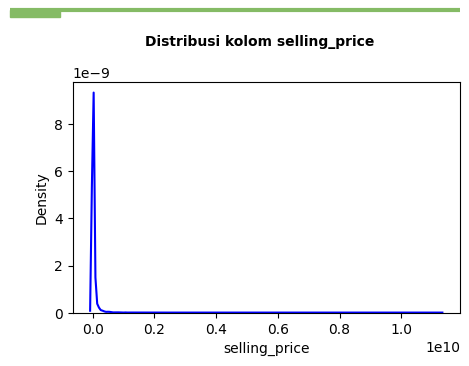

In [13]:
from matplotlib import lines, patches
# single color
COLOR = "#85bb65"

# inisialisasi plot
fig, ax = plt.subplots(figsize=(5,3))

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.1, 0.025, color=COLOR))

# judul grafik
fig.text(0.27, 1.0, "Distribusi kolom selling_price", fontsize=10, fontweight="bold")

sns.distplot(harvest['selling_price'], kde=True, hist=False, color='blue')

plt.show()

**2. Statistically**

Menggunakan uji statistik _Shapiro Wilk Test_

Interpretasi:
- Jika nilai p-value lebih **besar** dari 0.05, kita dapat mengasumsikan bahwa data tersebut memiliki distribusi **normal**
- Jika nilai p-value lebih **kecil** dari 0.05, kita dapat mengasumsikan bahwa data tersebut memiliki distribusi **TIDAK normal**

In [14]:
from scipy.stats import shapiro

stats, pvalue = shapiro(harvest['selling_price'].dropna())

if pvalue > 0.05:
    print(f"pvalue:{pvalue} --> Distribusi Normal")
else:
    print(f"pvalue:{pvalue} --> Distribusi Tidak Normal")
        

pvalue:0.0 --> Distribusi Tidak Normal


**_Insight_**:
- Berdasarkan _graphically_ dan _statistically_, data _selling_price_ pada harvest dataset memiliki jenis distribusi **tidak normal**

#### **Data Cleaning Summary Sebelum Analisis Data**
- _Mengganti _hatchery_id_ yang NaN menjadi 0 dan _hatchery_name_ menjadi "Tidak diketahui" pada cylces dataset. Kemudian, NaN pada kolom _remark_ diganti dengan "Tidak ada Remark". Lalu, _ordered_at__

- Mengisi _missing values_ pada kolom _selling_price_ pada **harvest dataset** dengan *median* karena data tersebut terdistribusi **tidak normal**.

## `Data Preprocessing`

## `Answers of Task`

>### 1. Evaluate the completeness of data

#### **Summary Evaluate the completeness of data**:
1. Tidak terdapat _feature description_ untuk dataset **feed_tray** dan **mortalities**
2. Terdapat _missing values_ yang lebih dari 10% pada beberapa kolom di beberapa dataset
3. Terdapat beberapa kolom tanggal yang masih memiliki tipe data "object"
4. Terdapat _negative value_ pada beberapa kolom yang tidak masuk akal
5. Terdapat duplikat data berdasarkan semua kolom terutama pada _feeds dataset_ yang memiliki jumlah paling banyak

>### 2. Calculate SR and average growth rate (ADG) of shrimp **per cultivation cycle**

**2.1. Survival Rate (SR)**

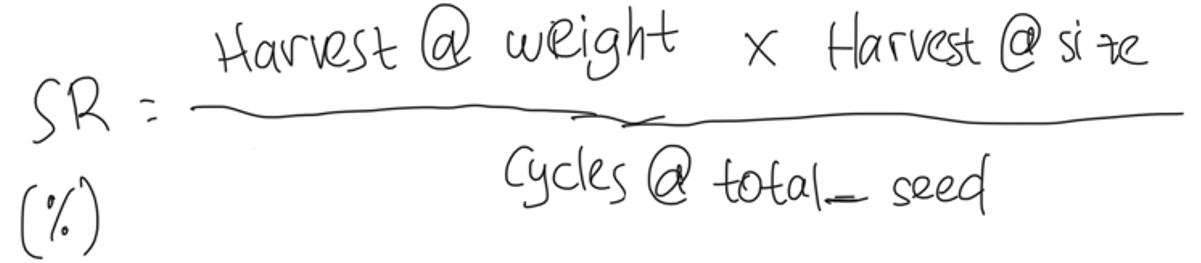

In [15]:
# load cycles data
cycles = pd.read_csv("../data/raw/cycles.csv", parse_dates=['started_at', 'finished_at', 'created_at', 'updated_at', 'extracted_at', 'ordered_at'])

# load harvest data
harvest = pd.read_csv("../data/raw/harvests.csv", parse_dates=['updated_at', 'created_at', 'harvested_at'])

# menambahkan kolom jumlah ekor udang ketika dipanen
harvest['jumlah_ekor'] = harvest['size']*harvest['weight']

2.1.1. Merging **cylces dataset** dan **harvest dataset**

_Merging_ dilakukan untuk mendapatkan _total_seed_ (jumlah benur ketika ditebar pada setiap kolam dan setiap siklus)

In [16]:
pd.reset_option("display.max_rows")

In [17]:
# jumlah benur pada setiap kolam
total_seed_pond = cycles.groupby('pond_id').agg({'total_seed': 'sum'}).reset_index()
total_seed_pond = total_seed_pond.merge(cycles, left_on='pond_id', right_on='pond_id', how='left')[['pond_id', 'id', 'total_seed_x']].rename(columns={'id':'cycle_id', 'total_seed_x': 'total_seed'})
total_seed_pond

,pond_id,cycle_id,total_seed
0,1,17186,523000
1,1,24977,523000
2,1,19669,523000
3,1,6319,523000
4,1,14094,523000
...,...,...,...
2612,47103,29212,118180
2613,47107,29216,118180
2614,47108,29215,118180
2615,47109,29213,130240


In [18]:
# melakukan inner join berdasarkan id siklus
sr_data = harvest.merge(total_seed_pond, on='cycle_id', how='inner')

In [19]:
# size_weight_harvest = harvest.groupby('cycle_id').agg({'size': 'mean', 'weight':'sum'}).reset_index()
# size_weight_harvest

In [20]:
# # melakukan inner join berdasarkan id siklus
# sr_data = total_seed_pond.merge(size_weight_harvest, on='cycle_id', how='inner')


In [21]:
# rata2 dari size dan weight udang yang dipanen pada setiap siklus dengan status panen Full atau Partial
#size_weight_harvest = harvest.query("status == 'Full' or status == 'Partial'").groupby('cycle_id').agg('mean')[['size', 'weight']].reset_index()

In [22]:
# melakukan inner join berdasarkan id siklus
#sr_data = cycles.merge(size_weight_harvest, left_on='id', right_on='cycle_id', how='inner').drop(columns='cycle_id')

# mengubah nama kolom 'id' menjadi 'cycle_id'
#sr_data.rename({'id':'cycle_id'})

2.1.2. Skimming data

In [23]:
# jumlah duplikat data
print(f"jumlah duplikat data: \x1b[31m{sr_data.loc[sr_data.duplicated()].shape[0]} baris\x1b[0m")

# skimming data
skim(sr_data, 'survival rate data')

jumlah duplikat data: 457 baris


,dataset,column,data_type,unique,null,null_pct,zero_value,neg_value,min,max,sample_unique
0,survival rate data,cycle_id,float64,2490,0,0.00,False,False,4038.0,29874.0,"[15013.0, 11848.0, 4666.0, 18747.0, 27095.0, 2..."
1,survival rate data,updated_at,datetime64[ns],5892,0,0.00,False,False,2020-06-07 13:33:19,2024-04-12 00:49:36,"[2022-07-18T08:42:59.000000000, 2021-10-25T23:..."
2,survival rate data,size,float64,1481,0,0.00,False,False,10.0,16000.0,"[399.86, 300.0, 110.0, 190.0, 72.3, 41.5, 67.5..."
3,survival rate data,created_at,datetime64[ns],7098,0,0.00,False,False,2020-06-07 13:33:19,2024-04-06 15:06:03,"[2022-07-18T08:42:59.000000000, 2021-10-24T08:..."
4,survival rate data,weight,float64,5109,0,0.00,True,False,0.0,250000.0,"[0.01, 46.0, 10.0, 270.5, 5322.28, 7843.0, 124..."
5,survival rate data,id,float64,8076,0,0.00,False,False,2166.0,28468.0,"[11960.0, 7520.0, 7546.0, 3009.0, 3010.0, 1387..."
6,survival rate data,harvested_at,datetime64[ns],1069,0,0.00,False,False,2020-05-30 00:00:00,2024-04-02 00:00:00,"[2022-04-17T00:00:00.000000000, 2021-10-22T00:..."
7,survival rate data,status,object,13,354,4.14,False,False,FINISIHING,Partial,"[Failed, Full, Partial, nan, FINISIHING, Trans..."
8,survival rate data,selling_price,float64,4981,1872,21.91,True,False,0.0,11250000000.0,"[nan, 1610000.0, 350000.0, 5322.28, 492540400...."
9,survival rate data,jumlah_ekor,float64,6824,0,0.00,True,False,0.0,40000000.0,"[3.9986, 13800.0, 3000.0, 29755.0, 51395.0, 38..."


**_Insight_**:
- Terdapat duplikat data sebanyak 117 baris
- **Tidak terdapat anomali data** pada kolom yang digunakan untuk menghitung Survival Rate (SR): total_seed, size, dan weight

2.1.3. Menghapus duplikat data

In [24]:
# menghapus duplikat data
sr_data = sr_data.drop_duplicates()

2.1.4. Menghitung **Survival Rate (SR)**

In [25]:
# conditional statements jika survival rate melebihi 100%, maka akan ditulis 100%
def survival_rate(df):
    if ((df['weight']*df['size'])/df['total_seed'])*100 > 100:
        return 100
    else:
        return ((df['weight']*df['size'])/df['total_seed'])*100

# menambahkan kolom survival rate
sr_data['survival_rate(%)'] = sr_data.apply(survival_rate, axis=1)

**_insight_**:
- Setelah dilakukan perhitungan survival rate, **terdapat anomali data**, yaitu:
    - Seharusnya survival rate tidak mungkin lebih dari 100%, namun pada kasus dataset ini terdapat jumlah panen yang melebihi jumlah benur yang ditebar, oleh karena itu maka survival rate diasumsikan 100%

In [26]:
# save survival rate dataset
sr_data.to_csv("../data/processed/survival_rate.csv", index=False)

**2.1. Average Daily Growth or Average Daily Gain (ADG)**

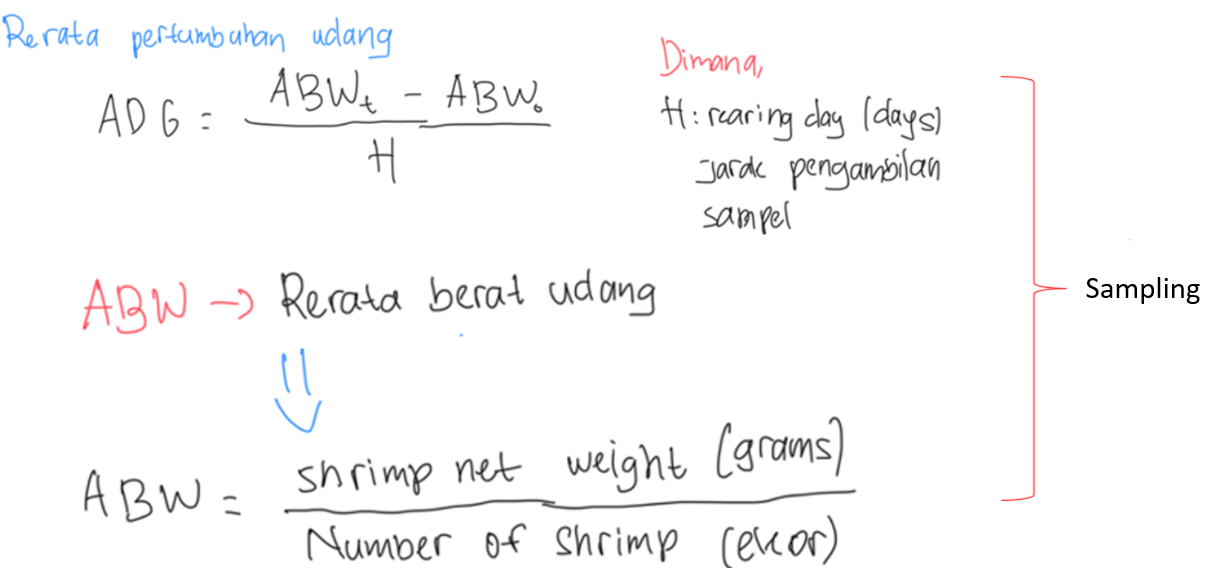

In [27]:
sampling = pd.read_csv("../data/raw/samplings.csv")
sampling.head()

,cycle_id,updated_at,sampled_at,created_at,average_weight,id,remark
0,18747.0,2022-10-07 03:26:30,2022-09-24,2022-10-07 02:10:49,4.91,32508.0,Size 204\nP/H = 99 kg\nP/K = 2.020 kg\nSamplin...
1,18747.0,2022-10-07 03:27:27,2022-10-01,2022-10-07 03:27:27,7.12,32534.0,"Size 140\nADG = 0,31\nP/H = 139 kg\nP/K = 2.88..."
2,18747.0,2022-10-08 01:30:56,2022-10-08,2022-10-08 01:30:56,9.75,32575.0,"Size 103\nADG = 0,38\nP/H = 160 kg\nP/K = 3.94..."
3,18747.0,2022-10-15 03:24:26,2022-10-15,2022-10-15 03:24:26,11.15,32864.0,"Size 90\nADG 0,23\nP/H = 180 kg\nP/K = 5.149 k..."
4,27095.0,2023-11-05 09:03:39,2023-10-07,2023-11-05 09:03:39,4.79,52037.0,NaN


In [28]:
spam = pd.concat([cycles, sampling])

# fillna cycle_id dengan id yang seharusnya
spam['cycle_id'] = spam['cycle_id'].fillna(spam['id'])

# menambahkan tanggal awal menebar benur
spam['sampled_at'] = spam['sampled_at'].fillna(spam['started_at'])
spam['sampled_at'] = pd.to_datetime(spam['sampled_at'])

# average_weight pada tanggal awal menebar benur adalah 0 karena tidak dilakukan sampling
spam['average_weight'] = spam['average_weight'].fillna(0)

# order by cycle_id dan tanggal pengambilan sampel
spam = spam.sort_values(by=['cycle_id', 'sampled_at'])[['cycle_id', 'sampled_at', 'average_weight']]

In [29]:
# ABWt - ABW0
spam['ABWt-ABW0'] = spam['average_weight'] - spam['average_weight'].shift(periods=1)

# ht-h0
spam['ht-h0'] = spam['sampled_at'] - spam['sampled_at'].shift(periods=1)
spam['ht-h0'] = pd.to_numeric(spam['ht-h0'].dt.days, downcast='integer') # mengubah timedelta menjadi integer

# fillna = 0
spam['ABWt-ABW0'] = spam['ABWt-ABW0'].fillna(0)
spam['ht-h0'] = spam['ht-h0'].fillna(0)

# if abwt-abw0 sama dengan nilai negatif maka, abwt-abw0 = 0. Negatif karena beda cycle_id dengan yang sebelumnya
spam['ABWt-ABW0'] = spam['ABWt-ABW0'].apply(lambda x : x if x > 0 else 0)

# if average_weight = 0, maka ht-h0 sama 0 (tidak ada pengukuran, karena awal penebaran benur)
spam['ht-h0'] = np.where(spam['average_weight'] == 0, 0, spam['ht-h0'])

# calculate ADG
spam['ADG'] = spam['ABWt-ABW0']/spam['ht-h0']
# menghapus baris yang ADG = 0 karena baris tersebut adalah awal penebaran benur
spam = spam.dropna()
# reset_index
spam = spam.reset_index().drop(columns='index')
spam

,cycle_id,sampled_at,average_weight,ABWt-ABW0,ht-h0,ADG
0,3458.0,2020-04-10,4.37,4.37,34.0,0.128529
1,3458.0,2020-04-17,5.23,0.86,7.0,0.122857
2,3458.0,2020-04-24,6.69,1.46,7.0,0.208571
3,3458.0,2020-05-01,8.21,1.52,7.0,0.217143
4,3458.0,2020-05-08,9.68,1.47,7.0,0.210000
...,...,...,...,...,...,...
14716,29874.0,2024-02-20,4.10,1.13,7.0,0.161429
14717,29874.0,2024-02-27,6.20,2.10,7.0,0.300000
14718,29874.0,2024-03-05,8.39,2.19,7.0,0.312857
14719,29874.0,2024-03-12,8.98,0.59,7.0,0.084286


In [30]:
# save adg file to processed data
spam.to_csv("../data/processed/adg.csv", index=False)

>### **3. Predictive modeling**

Proses pembuatan model akan **di-tracking** menggunakan MLFlow x Dagshub

##### 3.1. **Survival Rate (in percentage)** forecast for the end of cultivation or at the pointed day of cultivation (You need to make sure that the model performs well when the cultivation cycle is still ongoing). _Features_ yang dibutuhkan:

    - harvested_at
    - started_at
    - total_seed
    - quantity
    - size
    - morning_temperature
    - evening_temperature
    - morning_do
    - evening_do
    - morning_salinity
    - evening_salinity
    - morning_pH
    - evening_pH

>3.1.1. Dataset Preparation

In [31]:
# data for modelling survival rate
sr_data_model = sr_data[['cycle_id', 'harvested_at', 'total_seed', 'size', 'survival_rate(%)']]
sr_data_model

,cycle_id,harvested_at,total_seed,size,survival_rate(%)
0,15013.0,2022-04-17,798822,399.86,0.000501
1,11848.0,2021-10-22,105000,300.00,13.142857
2,11848.0,2021-10-21,105000,300.00,2.857143
3,4666.0,2020-08-31,65550,110.00,45.392830
4,4666.0,2020-08-31,65550,190.00,78.405797
...,...,...,...,...,...
8539,28500.0,2024-03-05,50000,90.00,2.160000
8540,28500.0,2024-02-02,50000,150.00,1.200000
8541,11741.0,2021-11-20,190000,80.00,7.705263
8542,11741.0,2021-11-20,190000,80.00,1.263158


In [32]:
feed = pd.read_csv("../data/raw/feeds.csv")
quantity = feed.groupby('cycle_id').agg({'quantity':'sum'}).reset_index()
quantity

,cycle_id,quantity
0,3458,9987.00
1,3459,10913.00
2,4036,480.10
3,4038,7790.60
4,4039,3770.50
...,...,...
2495,29619,1043.40
2496,29659,15.00
2497,29679,488.35
2498,29873,1798.80


In [33]:
started_at = cycles[['id', 'started_at']].rename(columns={'id':'cycle_id'})
started_at

,cycle_id,started_at
0,18876,2022-10-14
1,22118,2023-04-26
2,24088,2023-08-01
3,17743,2022-07-19
4,17125,2022-07-07
...,...,...
2612,19131,2022-10-25
2613,27552,2023-11-05
2614,27885,2023-12-02
2615,15868,2022-04-28


In [34]:
area = cycles[['id', 'area']].rename(columns={'id':'cycle_id'})

# drop duplikat data
area = area.drop_duplicates()

area

,cycle_id,area
0,18876,4030.0
1,22118,399.0
2,24088,2000.0
3,17743,1512.0
4,17125,1225.0
...,...,...
2612,19131,4999.9
2613,27552,900.0
2614,27885,86.0
2615,15868,1600.0


In [35]:
measurements = pd.read_csv("../data/raw/measurements.csv")
measurements = measurements.groupby('cycle_id').agg('mean').reset_index()[['cycle_id','morning_temperature','evening_temperature', 'morning_do', 'evening_do', 'morning_salinity','evening_salinity', 'morning_pH', 'evening_pH']]
measurements

,cycle_id,morning_temperature,evening_temperature,morning_do,evening_do,morning_salinity,evening_salinity,morning_pH,evening_pH
0,3458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2495,29619,29.250419,31.276903,4.260966,6.053214,13.398690,13.498571,8.083645,8.458417
2496,29659,30.328571,34.254545,2.430000,5.793636,11.798571,11.305455,8.454286,NaN
2497,29679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2498,29873,28.645455,29.625000,4.210909,4.332500,14.790909,14.025000,7.653636,9.755000


In [36]:
feed_tray = pd.read_csv("../data/raw/feed_tray.csv")
feed_tray

,id,logged_at,feed_logged_at,cycle_id,tray_number,feed_remaining_percent,remark,created_at,updated_at,local_feed_logged_at
0,498,2021-11-19 17:09:00,2021-11-20 04:09:00,12163,1,0,NaN,2021-11-20 04:12:03,2021-11-20 04:12:03,2021-11-20 00:09:00
1,499,2021-11-19 17:09:00,2021-11-20 04:09:00,12163,2,0,NaN,2021-11-20 04:12:03,2021-11-20 04:12:03,2021-11-20 00:09:00
2,500,2021-11-20 09:14:00,2021-11-20 08:14:00,12163,1,0,NaN,2021-11-20 08:15:17,2021-11-20 08:15:17,2021-11-20 16:14:00
3,501,2021-11-20 09:14:00,2021-11-20 08:14:00,12163,2,0,NaN,2021-11-20 08:15:17,2021-11-20 08:15:17,2021-11-20 16:14:00
4,1643,2021-12-13 02:00:00,2021-12-13 00:00:00,13112,2,0,"Anco 1 habis 30 menit, anco 2 55 menit",2021-12-14 01:18:59,2021-12-16 00:12:44,2021-12-13 09:00:00
...,...,...,...,...,...,...,...,...,...,...
186659,285946,2024-03-28 18:00:00,2024-03-29 00:00:00,27415,2,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00
186660,285947,2024-03-28 18:00:00,2024-03-29 03:30:00,27415,1,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00
186661,285948,2024-03-28 18:00:00,2024-03-29 03:30:00,27415,2,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00
186662,285949,2024-03-28 18:00:00,2024-03-29 05:30:00,27415,1,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00


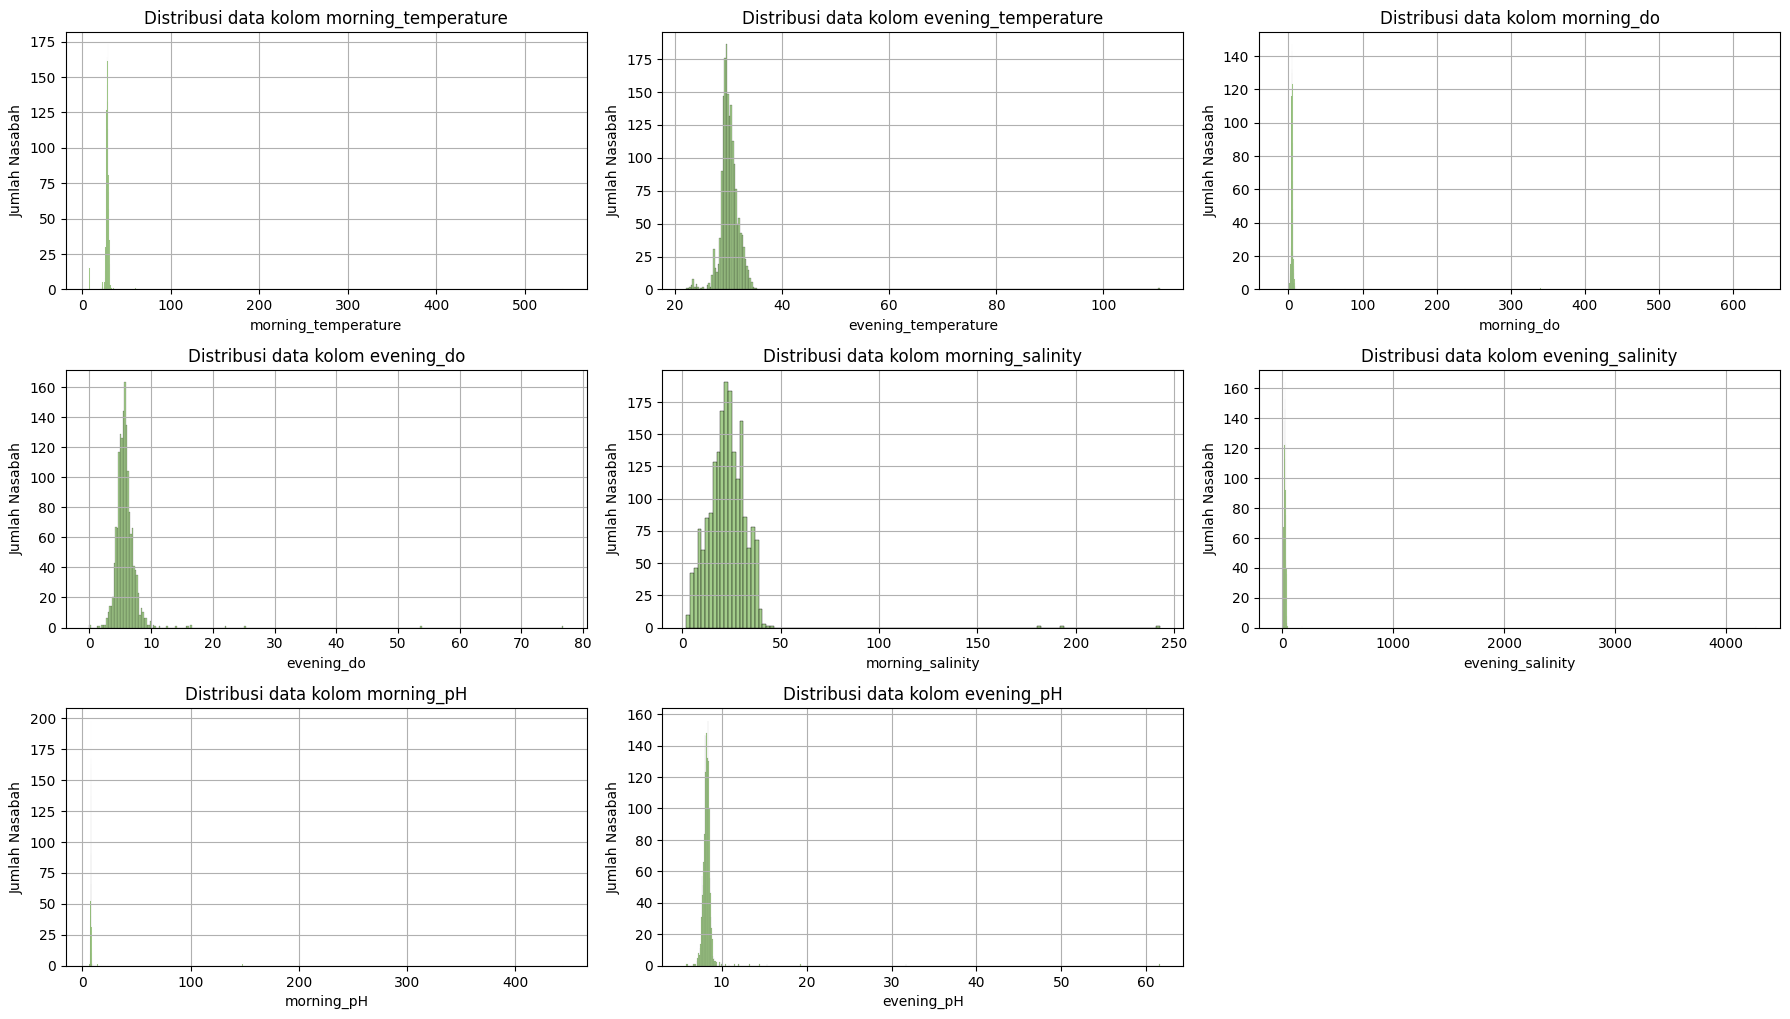

In [37]:
# plot distributi data dari semua kolom menggunakan histogram plot
count = 0
fig = plt.figure(figsize=(18, 20))
for feature in measurements.drop(columns='cycle_id').columns:
    count +=1
    ax = plt.subplot(6,3,count)
    sns.histplot(data=measurements.drop(columns='cycle_id'), x=feature, color=COLOR)
    plt.title(f"Distribusi data kolom {feature}")
    plt.ylabel("Jumlah Nasabah")
    fig.tight_layout()
    plt.grid(True)
plt.show()

In [38]:
# uji normalitas

from scipy.stats import shapiro

cols = measurements.drop(columns='cycle_id').columns

for col in cols:
    stats, pvalue = shapiro(measurements[col].dropna())

    if pvalue > 0.05:
        print(f"pvalue:{pvalue} --> Distribusi Normal")
    else:
        print(f"pvalue:{pvalue} --> Distribusi Tidak Normal")
        

pvalue:0.0 --> Distribusi Tidak Normal
pvalue:0.0 --> Distribusi Tidak Normal
pvalue:0.0 --> Distribusi Tidak Normal
pvalue:0.0 --> Distribusi Tidak Normal
pvalue:0.0 --> Distribusi Tidak Normal
pvalue:0.0 --> Distribusi Tidak Normal
pvalue:0.0 --> Distribusi Tidak Normal
pvalue:0.0 --> Distribusi Tidak Normal


In [39]:
# fillna dengan median karena distribusi tidak normal
for col in cols:
    measurements[col] = measurements[col].fillna(measurements[col].median())

In [40]:
sr_data_model = sr_data_model.merge(quantity, on='cycle_id', how='left')

sr_data_model = sr_data_model.merge(started_at, on='cycle_id', how='left')

sr_data_model = sr_data_model.merge(area, on='cycle_id', how='left')

sr_data_model = sr_data_model.merge(measurements, on='cycle_id', how='left')

sr_data_model
# sr_data_model['DoC'] = sr_data_model['harvested_at'] - sr_data_model['started_at']

,cycle_id,harvested_at,total_seed,size,survival_rate(%),quantity,started_at,area,morning_temperature,evening_temperature,morning_do,evening_do,morning_salinity,evening_salinity,morning_pH,evening_pH
0,15013.0,2022-04-17,798822,399.86,0.000501,156.00,2022-03-26,1998.00,28.782609,27.000000,5.009224,5.645352,25.695652,18.000000,8.030435,8.214017
1,11848.0,2021-10-22,105000,300.00,13.142857,75.00,2021-09-08,2230.00,28.254646,30.000000,5.009224,5.645352,22.754981,21.276507,7.912641,8.214017
2,11848.0,2021-10-21,105000,300.00,2.857143,75.00,2021-09-08,2230.00,28.254646,30.000000,5.009224,5.645352,22.754981,21.276507,7.912641,8.214017
3,4666.0,2020-08-31,65550,110.00,45.392830,315.50,2020-07-06,1800.00,28.254646,30.000000,5.009224,5.645352,22.754981,21.276507,7.912641,8.214017
4,4666.0,2020-08-31,65550,190.00,78.405797,315.50,2020-07-06,1800.00,28.254646,30.000000,5.009224,5.645352,22.754981,21.276507,7.912641,8.214017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539,28500.0,2024-03-05,50000,90.00,2.160000,545.23,2023-11-20,50.27,29.800000,30.000000,7.270000,5.645352,32.000000,21.276507,7.912641,8.214017
8540,28500.0,2024-02-02,50000,150.00,1.200000,545.23,2023-11-20,50.27,29.800000,30.000000,7.270000,5.645352,32.000000,21.276507,7.912641,8.214017
8541,11741.0,2021-11-20,190000,80.00,7.705263,625.00,2021-09-02,1000.00,28.254646,30.000000,5.009224,5.645352,22.754981,21.276507,7.912641,8.214017
8542,11741.0,2021-11-20,190000,80.00,1.263158,625.00,2021-09-02,1000.00,28.254646,30.000000,5.009224,5.645352,22.754981,21.276507,7.912641,8.214017


In [41]:
sr_data_model['DoC'] = sr_data_model['harvested_at'] - sr_data_model['started_at']

sr_data_model['DoC'] = pd.to_numeric(sr_data_model['DoC'].dt.days, downcast='integer')

# sr_data_model = sr_data_model.drop(columns=['harvested_at', 'started_at'])

In [42]:
# mengubah urutan kolom
sr_data_model = sr_data_model[['cycle_id', 'total_seed', 'quantity', 'size', 'started_at', 'harvested_at', 'DoC','area', 'morning_temperature', 'evening_temperature', 'morning_do', 'evening_do', 'morning_salinity', 'evening_salinity', 'morning_pH', 'evening_pH', 'survival_rate(%)']]

# skim dataset
skim(sr_data_model, 'survival rate model')

,dataset,column,data_type,unique,null,null_pct,zero_value,neg_value,min,max,sample_unique
0,survival rate model,cycle_id,float64,2490,0,0.0,False,False,3458.0,29874.0,"[15013.0, 11848.0, 4666.0, 18747.0, 27095.0, 2..."
1,survival rate model,total_seed,int64,775,0,0.0,False,False,100,4577414,"[798822, 105000, 65550, 492936, 450000, 107500..."
2,survival rate model,quantity,float64,2369,0,0.0,True,False,0.0,219525.5,"[156.0, 75.0, 315.5, 6084.0, 153554.0, 8450.0,..."
3,survival rate model,size,float64,1481,0,0.0,False,False,10.0,20000.0,"[399.86, 300.0, 110.0, 190.0, 72.3, 41.5, 67.5..."
4,survival rate model,started_at,datetime64[ns],748,0,0.0,False,False,2020-03-07 00:00:00,2024-02-18 00:00:00,"[2022-03-26T00:00:00.000000000, 2021-09-08T00:..."
5,survival rate model,harvested_at,datetime64[ns],1069,0,0.0,False,False,2008-05-08 00:00:00,2024-04-02 00:00:00,"[2022-04-17T00:00:00.000000000, 2021-10-22T00:..."
6,survival rate model,DoC,int16,195,0,0.0,True,False,-5419,419,"[22, 44, 43, 56, 65, 110, 76, 142, 87, 94, 47,..."
7,survival rate model,area,float64,641,0,0.0,False,False,1.02,422500.0,"[1998.0, 2230.0, 1800.0, 3249.0, 2500.0, 4999...."
8,survival rate model,morning_temperature,float64,1720,0,0.0,False,False,7.9,543.305396,"[28.782608695652176, 28.254646087949745, 27.5,..."
9,survival rate model,evening_temperature,float64,1664,0,0.0,False,False,22.071429,110.499091,"[27.0, 30.0, 29.0, 26.893124999999998, 30.6059..."


**_Insight_**:
- Terdapat anomali data, yaitu:
    - Ada nilai negatif pada kolom DoC (days of culture)
- Semua kolom bersifat numerik dan continuous, kecuali DoC, yaitu variabel diskrit
- Tidak terdapat _missing values_
- Tidak menggunakan kolom _started_at_ dan _harvested_at_ untuk membuat predictive model karena sudah tergantikan dengan _DoC_
- Tidak menggunakan kolom cycle_id untuk membuat predictive model karena tidak memberikan informasi apapun terkait dengan _modelling_

>3.1.2. Data Cleaning

Drop Negative Value --> karena jumlahnya data sedikit, sehingga tidak berpengaruh terhadap analisa selanjutnya

In [43]:
# DataFrame selain nilai DoC negatif
sr_data_model = sr_data_model.loc[~(sr_data_model['DoC'] < 0 )]

sr_data_model = sr_data_model.loc[~(sr_data_model['morning_do'] < 0 )]

# drop kolom cycle_id
sr_data_model = sr_data_model.drop(columns=['cycle_id', 'started_at', 'harvested_at'])

In [44]:
# skim dataset
skim(sr_data_model, 'survival rate')

,dataset,column,data_type,unique,null,null_pct,zero_value,neg_value,min,max,sample_unique
0,survival rate,total_seed,int64,775,0,0.0,False,False,100.000000,4.577414e+06,"[798822, 105000, 65550, 492936, 450000, 107500..."
1,survival rate,quantity,float64,2366,0,0.0,True,False,0.000000,2.195255e+05,"[156.0, 75.0, 315.5, 6084.0, 153554.0, 8450.0,..."
2,survival rate,size,float64,1475,0,0.0,False,False,10.000000,2.000000e+04,"[399.86, 300.0, 110.0, 190.0, 72.3, 41.5, 67.5..."
3,survival rate,DoC,int16,182,0,0.0,True,False,0.000000,4.190000e+02,"[22, 44, 43, 56, 65, 110, 76, 142, 87, 94, 47,..."
4,survival rate,area,float64,638,0,0.0,False,False,1.020000,4.225000e+05,"[1998.0, 2230.0, 1800.0, 3249.0, 2500.0, 4999...."
5,survival rate,morning_temperature,float64,1717,0,0.0,False,False,7.900000,5.433054e+02,"[28.782608695652176, 28.254646087949745, 27.5,..."
6,survival rate,evening_temperature,float64,1661,0,0.0,False,False,22.071429,1.104991e+02,"[27.0, 30.0, 29.0, 26.893124999999998, 30.6059..."
7,survival rate,morning_do,float64,1507,0,0.0,True,False,0.000000,6.311833e+02,"[5.009223536737235, 4.7, 5.650625, 4.695070422..."
8,survival rate,evening_do,float64,1538,0,0.0,True,False,0.000000,7.677803e+01,"[5.645352380952381, 5.033333333333334, 7.23656..."
9,survival rate,morning_salinity,float64,1792,0,0.0,False,False,1.973652,2.426460e+02,"[25.695652173913043, 22.754980537389073, 34.75..."


**_Insight_**:
- sudah tidak terdapat anomali data, sehingga data siap dianalisa ke langkat berikutnya

>3.1.3. Features Engineering

In [45]:
# membuat kolom baru yaitu tingkat kepadatan tebar
sr_data_model.insert(5,'padat_tebar',sr_data_model['total_seed']/sr_data_model['area'])

>3.1.3. Splitting

In [46]:
# features dan target
target = 'survival_rate(%)'
feature = sr_data_model.drop(columns=target).columns

In [47]:
# data spliting
train, test = train_test_split(sr_data_model, test_size=0.20, random_state=42)

print(train.shape, test.shape)

(6810, 15) (1703, 15)


>3.1.3. Scalling

In [48]:
# continue column
cont_column = ['total_seed', 'quantity', 'size', 'padat_tebar', 'morning_temperature', 'evening_temperature', 'morning_do', 'evening_do', 'morning_salinity', 'evening_salinity', 'morning_pH', 'evening_pH']

# ColumnTransformer untuk scaling
ct_1 = ColumnTransformer([
                ('scaler', RobustScaler(), cont_column),
                ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

>3.1.3. Benchmark Model

- Random Forest
- AdaBoost
- XGBoost
- LGBM
- CatBoost

In [49]:
# dagshub and mlflow setup
DAGSHUB_USERNAME = 'fnkhairudin'
DAGSHUB_EMAIL = 'fnkhairudin@gmail.com'
DAGSHUB_REPO = 'Assignment_JALA'
DAGSHUB_TOKEN = 'b1b10b82350be145d4ea4d0d14d8514de68ae6cf' # dagshub.auth.get_token()
DASGHUB_URI = f'https://dagshub.com/{DAGSHUB_USERNAME}/{DAGSHUB_REPO}.mlflow'

os.environ['MLFLOW_TRACKING_USERNAME'] = DAGSHUB_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = DAGSHUB_TOKEN
os.environ['MLFLOW_TRACKING_URI'] = DASGHUB_URI

In [53]:
# fungsi untuk melakukan model training
def log_training_model(est, 
                       model_name:str, 
                       score_result:list, 
                       target_name,
                       dataset:pd.DataFrame, 
                       name_experiment:str, 
                       **kwargs
                       ):
    """Fungsi untuk melakukan training model dan logging pada dagshub x mlflow

    ## Parameters:
        est : Estimator object
        model_name : Estimator name
        score_result : Empty list to store the metric result
        dataset : train dataset
        name_experiment : experiment name

    ## Return:
        None
    """
    # model params
    mlflow.log_params(est.get_params())

    # pipeline
    pipe = Pipeline([
                ('preprocess_1', ct_1), # scaling RobustScaller
                ('model', est)
                ]).set_output(transform='pandas')
    
    # ytrain
    ytrain = dataset[target_name]

    # training model
    print(f"training model {model_name}", end='\r')
    pipe.fit(dataset.drop(columns=target_name), ytrain)
    
    # hasil prediksi
    ypred = pipe.predict(dataset.drop(columns=target_name))

    # set_tag
    tags = {"model_name": model_name, "experiment-n": name_experiment,}
    # tags untuk mlflow ui
    mlflow.set_tags(tags)

    # hasil metrik evaluasi
    score_result.append({
    'Model' : model_name,
    'MAE': mean_absolute_error(ytrain, ypred),
    'r2_score': r2_score(ytrain, ypred),
    **kwargs
    })

    # log metrics pada mlflow ui
    mlflow.log_metrics({
                    'MAE': mean_absolute_error(ytrain, ypred),
                    'r2_score': r2_score(ytrain, ypred),
                    })
    
    # log model pada mlflow ui
    mlflow.sklearn.log_model(est, "sk_model")
    
    print(f"training model {model_name} is DONE.", end='\r')

In [54]:
# Model
rf = RandomForestRegressor(random_state=42)
ada = AdaBoostRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42, verbosity=0)
catboost = CatBoostRegressor(random_state=42, verbose=False)

# Collect Models
models = {
    'RandomForestRegressor': rf,
    'AdaBoostRegressor': ada,
    'XGBRegressor': xgb,
    'LGBMRegressor': lgbm,
    'CatBoostRegressor' : catboost
    }

# hasil metrik evaluasi
metric_result = []

# melakukan set up the mlflow uri untuk tracking hasil eksperiment
mlflow.set_tracking_uri(DASGHUB_URI)

# melakukan tracking eksperiment menggunakan mlflow
for name, estimator in models.items(): 
    with mlflow.start_run(experiment_id=EXP_ID):
        # call fungsi untuk training model dan logging di mlflow
        log_training_model(est=estimator, 
                           model_name=name, 
                           score_result=metric_result,
                           target_name='survival_rate(%)',
                           dataset=train,
                           name_experiment='experiment-2'
                           )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [57]:
# menampilkan hasil model training
metric_result_df = pd.DataFrame(metric_result)
metric_result_df.sort_values(by='MAE').style.\
    highlight_min(subset=['MAE'], props=PROPS).\
    highlight_max(subset=['r2_score'], props=PROPS)

,Model,MAE,r2_score
0,RandomForestRegressor,4.138811,0.833009
2,XGBRegressor,4.869386,0.811634
4,CatBoostRegressor,6.239419,0.722532
3,LGBMRegressor,6.898138,0.663788
1,AdaBoostRegressor,17.744585,-0.349100


In [58]:
# melakukan cross validasi

# Model
rf = RandomForestRegressor(random_state=42)
ada = AdaBoostRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42, verbosity=0)
catboost = CatBoostRegressor(random_state=42, verbose=False)

# Collect Models
models = {
    'RandomForestRegressor': rf,
    'AdaBoostRegressor': ada,
    'XGBRegressor': xgb,
    'LGBMRegressor': lgbm,
    'CatBoostRegressor' : catboost
    }

result = []

for name, est in models.items():
    
    crossval = KFold(n_splits=5, shuffle=True, random_state=42)

    estimator = Pipeline([
        ('preproces', ct_1),
        ('model', est)
    ])

    # MAE
    mae = cross_val_score(
        estimator, 
        train[feature], 
        train[target], 
        cv=crossval, 
        scoring='neg_mean_absolute_error'
        )

    # # MAPE
    # mape = cross_val_score(
    #     estimator, 
    #     train[feature], 
    #     train[target], 
    #     cv=crossval, 
    #     scoring='neg_mean_absolute_percentage_error'
    #     )

    # R2
    r2  =  cross_val_score(
        estimator, 
        train[feature], 
        train[target], 
        cv = crossval, 
        scoring = 'r2'
        )
    
    # Adjusted R2
    res = []
    for val in r2:
        res.append(adj_r2(val, len(train), len(feature)))

    # Collect Result
    result.append(
        {
            'Model': name,
            'MAE': abs(mae.mean()),
            # 'MAPE': abs(mape.mean()),
            'r2':r2.mean(),
            'Adj-r2':np.array(res).mean(),
            'std-MAE': statistics.stdev(mae),
            # 'std-MAPE': statistics.stdev(mape),
        }
    )

resultDf = pd.DataFrame(result).set_index('Model')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

In [59]:
# menampilkan hasil cross validation
resultDf.sort_values(by='MAE')\
    .style.\
    highlight_max(subset=['r2'], axis = 0, props=PROPS).\
    highlight_min(subset=['MAE','MAPE'], axis = 0, props=PROPS)

,MAE,MAPE,r2,Adj-r2,std-MAE,std-MAPE
Model,,,,,,
CatBoostRegressor,8.934611,169756649434844.781250,0.379847,0.378569,0.182897,131269777348496.875000
LGBMRegressor,9.073038,158789776088369.562500,0.372574,0.371281,0.162840,127926667288032.578125
RandomForestRegressor,9.172507,180700790375059.343750,0.301830,0.300392,0.190255,123229870446849.281250
XGBRegressor,9.275738,166312499282005.187500,0.297819,0.296373,0.188235,114710965352435.687500
AdaBoostRegressor,16.064183,207177776411214.062500,-0.194928,-0.197390,1.403346,156440587336555.531250


**_Insight_**:
- Setelah melakukan komparasi model hasil training dengan hasil _cross validation_, ternyata model masih **_overfitting_** karena performanya bagus ketika di data training, namun ketika dilakukan _cross validation_, hasil performanya menurun

##### 3.2. **Average Body Weight of Shrimp (in grams) forecast**. _Features_ yang dibutuhkan:

    - started_at
    - sampled_at
    - quantity
    - total_seed
    - average_weight

In [ ]:
# sampling dataset untuk mengambil sampled_at dan average_weight
sampling = pd.read_csv("../data/raw/samplings.csv", parse_dates=['updated_at', 'sampled_at', 'created_at'])

# mengambil sampled_at, average_weight, dan drop duplicates data
abw_sampling = sampling[['cycle_id', 'sampled_at', 'average_weight']].drop_duplicates()

abw_sampling

,cycle_id,sampled_at,average_weight
0,18747.0,2022-09-24,4.91
1,18747.0,2022-10-01,7.12
2,18747.0,2022-10-08,9.75
3,18747.0,2022-10-15,11.15
4,27095.0,2023-10-07,4.79
...,...,...,...
15027,11741.0,2021-11-10,11.14
15028,11741.0,2021-11-17,11.38
15029,24650.0,2023-09-08,3.41
15030,24650.0,2023-09-15,3.48


In [ ]:
feed

,cycle_id,logged_at,quantity
0,15013,2022-03-29 00:00:00.000,0.5
1,15013,2022-03-29 05:30:00.000,0.5
2,15013,2022-03-29 11:30:00.000,0.5
3,15013,2022-03-29 14:30:00.000,0.5
4,15013,2022-03-30 00:00:00.000,0.5
...,...,...,...
706903,24650,2023-09-15 21:47:00.000,10.0
706904,24650,2023-09-19 00:00:00.000,13.2
706905,24650,2023-09-20 00:00:00.000,14.0
706906,24650,2023-09-21 13:54:00.000,10.0


In [ ]:
# load dataset feed
feed = pd.read_csv("../data/raw/feeds.csv", parse_dates=['logged_at'])

# mengambil kolom quantity
abw_feed = feed[['cycle_id', 'quantity']]

# dropna pada kolom quantity
abw_feed = abw_feed.dropna()

# group by berdasarkan cycle_id kemundian quantity dirata2
abw_feed = abw_feed.groupby('cycle_id').agg('mean').reset_index()

abw_feed

,cycle_id,quantity
0,3458,89.972973
1,3459,90.190083
2,4036,12.634211
3,4038,16.790086
4,4039,8.022340
...,...,...
2495,29619,4.875701
2496,29659,0.375000
2497,29679,2.160841
2498,29873,12.405517


In [ ]:
cycles = pd.read_csv("../data/raw/cycles.csv", parse_dates=['started_at'])

# mengambil started_at dan total_seed
abw_cycles = cycles[['id','started_at', 'total_seed']]

# drop duplikat data
abw_cycles = abw_cycles.drop_duplicates()
abw_cycles

,id,started_at,total_seed
0,18876,2022-10-14,331920
1,22118,2023-04-26,40000
2,24088,2023-08-01,357570
3,17743,2022-07-19,168275
4,17125,2022-07-07,188000
...,...,...,...
2612,19131,2022-10-25,300000
2613,27552,2023-11-05,100000
2614,27885,2023-12-02,30716
2615,15868,2022-04-28,150000


In [ ]:
abw_sampling

,cycle_id,sampled_at,average_weight
0,18747.0,2022-09-24,4.91
1,18747.0,2022-10-01,7.12
2,18747.0,2022-10-08,9.75
3,18747.0,2022-10-15,11.15
4,27095.0,2023-10-07,4.79
...,...,...,...
15027,11741.0,2021-11-10,11.14
15028,11741.0,2021-11-17,11.38
15029,24650.0,2023-09-08,3.41
15030,24650.0,2023-09-15,3.48


In [ ]:
feed

,cycle_id,logged_at,quantity
0,15013,2022-03-29 00:00:00,0.5
1,15013,2022-03-29 05:30:00,0.5
2,15013,2022-03-29 11:30:00,0.5
3,15013,2022-03-29 14:30:00,0.5
4,15013,2022-03-30 00:00:00,0.5
...,...,...,...
706903,24650,2023-09-15 21:47:00,10.0
706904,24650,2023-09-19 00:00:00,13.2
706905,24650,2023-09-20 00:00:00,14.0
706906,24650,2023-09-21 13:54:00,10.0
